<a href="https://colab.research.google.com/github/GrantCanty/BDT_STC/blob/main/project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Getting Started

##Import needed modules

In [4]:
! pip install opencage
! pip install herepy

In [5]:
import duckdb
from google.colab import drive
import pandas as pd
import calendar
import gdown
import matplotlib.pyplot as plt
import seaborn as sns
import re
import herepy
import time as t
from opencage.geocoder import OpenCageGeocode
import numpy as np
from packaging import version
import tensorflow as tf
import sys
import sklearn.preprocessing as pre

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [6]:
if not tf.config.list_physical_devices('GPU'):
    print("No GPU was detected. Neural nets can be very slow without a GPU.")
    if "google.colab" in sys.modules:
        print("Go to Runtime > Change runtime and select a GPU hardware "
              "accelerator.")
    if "kaggle_secrets" in sys.modules:
        print("Go to Settings > Accelerator and select GPU.")

#Create data warehouse

##Download files

In [7]:
SHARED_FOLDER_ID = "13rT3mFZ2AKhQe3BOQkAxn8mnN3-kd3Yt"
gdown.download_folder(f'https://drive.google.com/drive/folders/{SHARED_FOLDER_ID}')
conn = duckdb.connect('bdt_project/my_database.db')

Retrieving folder contents


Processing file 15GNjvmlMb9bgIf6VFXlKDoiU-m1oo7Td 1-s2.0-S0303264718301333-main.pdf
Processing file 1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE BDT - Slide report template
Processing file 1sXnmIhCoVRuZmQPhT8enRk8_eNkMM3mT bins_and_garages.csv
Processing file 1GCJjr8yJR23ZWTgM-gX5Z3FFQU42-v70 Borough_And_Community_District_Size.csv
Processing file 1WrFDqdkVc1PEjRj7jSlKQw-1XI6ZDzOPUUFqcFmODYs Borough_And_Community_zip
Processing file 1OAr8CDu9FRQ62HRzCgvHcvit9Cfpz4Mx DSNY_Frequencies_20250210.csv
Processing file 1ov7qV3Pl1Qx9d4Gt9OGhh-NbQVBP_KMm DSNY_Garages_20250210.csv
Processing file 1e_sRi1MpDGDQApu0641nGqHs0Nyfy-2j DSNY_Monthly_Tonnage_Data.csv
Processing file 1TZ46-LAHdmNyt_ct4XIas9Ab_NlT3GZL DSNY_Special_Waste_Drop-off_Sites_20250204.csv
Processing file 1LBRYIoisJE1dy8ohYHrPRwpPLygpqNng graph.json
Processing file 1cXXZSKWFNU2snujiczMLpifFkM5V8Ob_ Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv
Processing file 1-47JasxsUfpjP6NDFrWzRugeXIq_JiZe my

Retrieving folder contents completed
Building directory structure
Building directory structure completed
Downloading...
From: https://drive.google.com/uc?id=15GNjvmlMb9bgIf6VFXlKDoiU-m1oo7Td
To: /content/bdt_project/1-s2.0-S0303264718301333-main.pdf
100%|██████████| 2.83M/2.83M [00:00<00:00, 35.5MB/s]
Downloading...
From (original): https://drive.google.com/uc?id=1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE
From (redirected): https://docs.google.com/presentation/d/1xczJQ7N_H_UrnMnmrT0NR0bZuLeZVAQZNWvgsUvmoEE/export?format=pptx
To: /content/bdt_project/BDT - Slide report template
60.0kB [00:00, 1.49MB/s]
Downloading...
From: https://drive.google.com/uc?id=1sXnmIhCoVRuZmQPhT8enRk8_eNkMM3mT
To: /content/bdt_project/bins_and_garages.csv
100%|██████████| 8.86k/8.86k [00:00<00:00, 21.7MB/s]
Downloading...
From: https://drive.google.com/uc?id=1GCJjr8yJR23ZWTgM-gX5Z3FFQU42-v70
To: /content/bdt_project/Borough_And_Community_District_Size.csv
100%|██████████| 946/946 [00:00<00:00, 3.83MB/s]
Down

##Make tables

###Make Weather table

In [ ]:
table_name = "weather"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  precipitation FLOAT,
  snow_fall FLOAT,
  snow_depth FLOAT,
  min_temp FLOAT,
  max_temp FLOAT,
);"""
)

In [ ]:
# clear table and load data
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM '/content/bdt_project/NYC_Central_Park_weather_1869-2022.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

###Make tonnage table
mgp tons is metal, glass, plastic


In [ ]:
table_name = "tonnage"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  date DATE,
  borough_name STRING,
  community_district STRING,
  refuse_tons DOUBLE,
  paper_tons DOUBLE,
  mgp_tons DOUBLE,
  res_organic_tons DOUBLE,
  school_organic_tons DOUBLE,
  leaves_tons DOUBLE,
  xmas_tree_tons DOUBLE,
  borough_id INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Monthly_Tonnage_Data.csv')

transform.rename(columns={
    'MONTH': 'date',
    'BOROUGH': 'borough_name',
    'COMMUNITYDISTRICT': 'community_district',
    'REFUSETONSCOLLECTED': 'refuse_tons',
    'PAPERTONSCOLLECTED': 'paper_tons',
    'MGPTONSCOLLECTED': 'mgp_tons',
    'RESORGANICSTONS': 'res_organic_tons',
    'SCHOOLORGANICTONS': 'school_organic_tons',
    'LEAVESORGANICTONS': 'leaves_tons',
    'XMASTREETONS': 'xmas_tree_tons',
    'BOROUGH_ID': 'borough_id'
}, inplace=True)

transform['date'] = transform['date'].apply(lambda x: f"{x} / {calendar.monthrange(int(x[:4]), int(x[-2:]))[1]}")
transform['date'] = pd.to_datetime(transform['date'], format='%Y / %m / %d')

transform.to_csv('temp_tonnage_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_tonnage_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make recycling and diversion rates tables

In [ ]:
table_name = "recycling"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  zone STRING,
  district STRING,
  total_diversion_rate FLOAT,
  paper_capture_rate FLOAT,
  mgp_capture_rate FLOAT,
  total_caputre_rate FLOAT,
  date DATE
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Recycling_Diversion_and_Capture_Rates_20250204.csv')

transform.rename(columns={
    'Zone': 'zone',
    'District': 'district',
    'Fiscal Month Number': 'month',
    'Fiscal Year': 'year',
    'Month Name': 'month_name',
    'Diversion Rate-Total (Total Recycling / Total Waste)': 'total_diversion_rate',
    'Capture Rate-Paper (Total Paper / Max Paper)': 'paper_capture_rate',
    'Capture Rate-MGP (Total MGP / Max MGP)': 'mgp_capture_rate',
    'Capture Rate-Total ((Total Recycling - Leaves (Recycling)) / (Max Paper + Max MGP))x100': 'total_caputre_rate'
}, inplace=True)

transform['month'] = transform['month'].apply(lambda x: (x + 6) % 12)
transform['month'] = transform['month'].apply(lambda x: 12 if x == 0 else x)

transform['date'] = transform.apply(lambda x: f"{x['year']}-{x['month']}-{calendar.monthrange(x['year'], x['month'])[1] }", axis=1)
transform['date'] = pd.to_datetime(transform['date'], format='%Y-%m-%d')
transform.drop(columns=['month', 'month_name', 'year'], inplace=True)

transform.to_csv('temp_recycling_data.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_recycling_data.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make population table

In [ ]:
table_name = "population"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  CD_Number INTEGER,
  CD_Name STRING,
  Population_1970 INTEGER,
  Population_1980 INTEGER,
  Population_1990 INTEGER,
  Population_2000 INTEGER,
  Population_2010 INTEGER,
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/New_York_City_Population_By_Community_Districts_20250204.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'CD Number': 'CD_Number',
    'CD Name': 'CD_Name',
    '1970 Population': 'Population_1970',
    '1980 Population': 'Population_1980',
    '1990 Population': 'Population_1990',
    '2000 Population': 'Population_2000',
    '2010 Population': 'Population_2010'
}, inplace=True)

transform.to_csv('temp_community_population.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_community_population.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Area Table

In [ ]:
table_name = "area"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  Borough STRING,
  CD_Number INTEGER,
  Square_Miles FLOAT
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Borough_And_Community_District_Size.csv')

transform.rename(columns={
    'Borough': 'Borough',
    'CD Number': 'CD_Number',
    'Square Miles': 'Square_Miles'
}, inplace=True)

transform.to_csv('temp_size.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_size.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Bins table

In [ ]:
table_name = "bins"
conn.execute(f"""
CREATE TABLE IF NOT EXISTS {table_name} (
  dsny_zone STRING,
  dsny_district VARCHAR,
  site_type STRING,
  site_location VARCHAR,
  partner STRING,
  paper_bins INTEGER,
  mgp_bins INTEGER
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/Public_Recycling_Bins_20250204.csv')

transform.rename(columns={
    'DSNY Zone': 'dsny_zone',
    'DSNY District': 'dsny_district',
    'Site type': 'site_type',
    'Site Location': 'site_location',
    'Partner': 'partner',
    'Paper Bins': 'paper_bins',
    'MGP Bins': 'mgp_bins'
}, inplace=True)

transform.to_csv('temp_public_recycling_bins.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_recycling_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Garages Table

In [ ]:
table_name = "garages"
conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    address STRING,
    boro INTEGER,
    borocd INTEGER,
    city STRING,
    distrtict_code VARCHAR,
    name VARCHAR,
    object_id INTEGER,
    state STRING,
    zip INTEGER,
    longitude FLOAT,
    latitude FLOAT
);"""
)

In [ ]:
transform = pd.read_csv('/content/bdt_project/DSNY_Garages_20250210.csv')

#transform.new_column = transform.apply(lambda row: f"POINT({row['longitude']} {row['latitude']})", axis=1)
transform.loc[transform['point'] != ' ', 'longitude'] = ' '
transform.loc[transform['point'] != ' ', 'latitude'] = ' '

def add_lat_and_long(row):
  #print(row['point'][7:-1].split(' '))
  row['longitude'] = row['point'][7:-1].split(' ')[0]
  row['latitude'] = row['point'][7:-1].split(' ')[1]
  #print(long, lat)
  return row

transform = transform.apply(add_lat_and_long, axis=1)

In [ ]:
transform.drop(columns=['BBL', 'BIN', 'TYPE', 'point'], inplace=True)

transform.rename(columns={
    'ADDRESS': 'address',
    'BORO': 'boro',
    'BOROCD': 'borocd',
    'CITY': 'city',
    'DISTRICTCODE': 'distrtict_code',
    'NAME': 'name',
    'OBJECTID': 'object_id',
    'STATE': 'state',
    'ZIP': 'zip',
}, inplace=True)

transform.to_csv('temp_public_garages.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_public_garages.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

###Make Frequencies table?
how often different routes happen

###Make Location of Dispoal Facilities Tables

In [ ]:
table_name = 'disposal_facilities'

conn.execute(f"""
  CREATE TABLE IF NOT EXISTS {table_name} (
    name VARCHAR,
    unique_id INTEGER,
    type STRING,
    address STRING,
    borough STRING,
    state STRING,
    zip INTEGER,
    latitude FLOAT,
    longitude FLOAT
);""")

In [ ]:
transform = pd.read_csv('/content/bdt_project/Location_of_Disposal_Facilities_and_Sites_Used_for_DSNY-Managed_Waste_20250210.csv')
transform.drop(columns=['Point'], inplace=True)

transform.rename(columns={
    'Name': 'address',
    'Unique ID': 'boro',
    'Type': 'borocd',
    'Street Address': 'city',
    'Borough/City': 'distrtict_code',
    'State': 'name',
    'Zipcod': 'object_id',
    'Latitude': 'state',
    'Longitude': 'zip',
}, inplace=True)


transform.to_csv('temp_disposal_facilities.csv', index=False)

In [ ]:
conn.execute(f"TRUNCATE TABLE {table_name};")
conn.execute(f"COPY {table_name} FROM 'temp_disposal_facilities.csv' (AUTO_DETECT TRUE, HEADER TRUE)")

##Data Validation
write a function that checks each column to see if there are missing values

In [ ]:
"""tables = conn.execute("SHOW ALL;").fetchdf()['name']

# Loop through each table
for table_name in tables:
    print(f"📌 Table Name: {table_name}")

    # Get column names and types
    columns_info = conn.execute(f"PRAGMA table_info('{table_name}')").fetchall()
    columns = [col[1] for col in columns_info]  # Column names
    column_types = {col[1]: col[2] for col in columns_info}  # Column name -> Data type

    # Query to count NULL values
    null_query = "SELECT " + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in columns]) + f" FROM {table_name}"
    missing_values = conn.execute(null_query).fetchdf()
    print(missing_values)

    # Fetch full table data
    df = conn.execute(f"SELECT * FROM {table_name}").fetchdf()

    # Loop through numeric columns and plot histograms & boxplots
    for col in columns:
        if column_types[col] in ('INTEGER', 'BIGINT', 'DOUBLE', 'FLOAT', 'DECIMAL'):  # Check if numeric
            print(f"🔹 Plotting distribution for column: {col}")

            # Create figure for plots
            fig, axes = plt.subplots(1, 2, figsize=(12, 4))

            # Histogram with KDE
            sns.histplot(df[col].dropna(), kde=True, ax=axes[0], bins=20, color='blue')
            axes[0].set_title(f"Histogram: {col}")

            # Boxplot
            sns.boxplot(x=df[col].dropna(), ax=axes[1], color='orange')
            axes[1].set_title(f"Boxplot: {col}")

            plt.show()"""

'tables = conn.execute("SHOW ALL;").fetchdf()[\'name\']\n\n# Loop through each table\nfor table_name in tables:\n    print(f"📌 Table Name: {table_name}")\n\n    # Get column names and types\n    columns_info = conn.execute(f"PRAGMA table_info(\'{table_name}\')").fetchall()\n    columns = [col[1] for col in columns_info]  # Column names\n    column_types = {col[1]: col[2] for col in columns_info}  # Column name -> Data type\n\n    # Query to count NULL values\n    null_query = "SELECT " + ", ".join([f"SUM(CASE WHEN {col} IS NULL THEN 1 ELSE 0 END) AS {col}_nulls" for col in columns]) + f" FROM {table_name}"\n    missing_values = conn.execute(null_query).fetchdf()\n    print(missing_values)\n\n    # Fetch full table data\n    df = conn.execute(f"SELECT * FROM {table_name}").fetchdf()\n\n    # Loop through numeric columns and plot histograms & boxplots\n    for col in columns:\n        if column_types[col] in (\'INTEGER\', \'BIGINT\', \'DOUBLE\', \'FLOAT\', \'DECIMAL\'):  # Check if numer

#Clean Data

##Clean Bins Data

In [ ]:
bins = conn.execute("SELECT * FROM bins").fetchdf()

bins = bins.dropna()

bins.to_csv('temp_bins.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE bins;")
conn.execute(f"COPY bins FROM 'temp_bins.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Weather Data

###Snow Depth Projections
take yesterday's snow depth and add today's snowfall

In [ ]:
weather = conn.execute("SELECT * FROM weather").fetchdf()
weather['snow_fall'] = weather['snow_fall'].fillna(0)
weather['snow_depth_t-1'] = weather['snow_depth'].shift(1)
weather['snow_depth_t-1'] = weather['snow_depth_t-1'].fillna(0)

In [ ]:
weather['snow_depth'] = weather['snow_depth'].fillna(weather['snow_depth_t-1'] + weather['snow_fall'])
weather.drop(columns=['snow_depth_t-1'], inplace=True)

# weather.head(16649)

###Clean Max & Min Missing Temps

do average of future few years for max and min temp. we would look at the past but the missing data is from 1869, the first year when data started being collected. no way to look at past data in this case

In [ ]:
# Ensure that 'date' is in datetime format
weather['date'] = pd.to_datetime(weather['date'])

# Extract the year and month from the 'date' column
weather['year'] = weather['date'].dt.year
weather['month'] = weather['date'].dt.month

# Function to fill missing values using data from the next 3 years for the same month
def fill_missing_with_future_years_mean(row, temp_column):
    # Get the year and month of the row with missing value
    year = row['year']
    month = row['month']

    # Filter data for the next 3 years (including the current row's year)
    future_years_data = weather[(weather['year'] >= year) & (weather['year'] <= year + 2) & (weather['month'] == month)]

    # Calculate the mean of the next 3 years for that month
    mean_value = future_years_data[temp_column].mean() if not future_years_data[temp_column].isnull().all() else None

    return mean_value

# Apply the function to fill missing values for 'max_temp' and 'min_temp'
for idx, row in weather[weather['max_temp'].isnull()].iterrows():
    weather.at[idx, 'max_temp'] = fill_missing_with_future_years_mean(row, 'max_temp')

for idx, row in weather[weather['min_temp'].isnull()].iterrows():
    weather.at[idx, 'min_temp'] = fill_missing_with_future_years_mean(row, 'min_temp')

# drop the 'year' and 'month' columns
weather = weather.drop(columns=['year', 'month'])


# Check the result
#weather.head(124)

make csv file and save csv to database

In [ ]:
weather.to_csv('temp_weather.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE weather;")
conn.execute(f"COPY weather FROM 'temp_weather.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

##Clean Tonnage Data

In [ ]:
tonnage = conn.execute("SELECT * FROM tonnage").fetchdf()

In [ ]:
tonnage['xmas_tree_tons'] = tonnage['xmas_tree_tons'].fillna(0)
tonnage['leaves_tons'] = tonnage['leaves_tons'].fillna(0)

borough_id
Staten Island = 5, Queens = 4, Brooklyn = 3, Bronx = 2, Manhattan = 1

In [ ]:
tonnage['borough_id'] = tonnage['borough_name'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))

finds rows where there is a missing value for refuse_tons and replaces null value with avg of its borough_id

In [ ]:
missing_vals = tonnage[tonnage['refuse_tons'].isnull()]

for idx, missing_val in missing_vals.iterrows():
    borough_id = missing_val['borough_id']
    community_district = missing_val['community_district']

    mean_refuse_tons = tonnage[tonnage['borough_id'] == 4]['refuse_tons'].mean()

    # Update the original tonnage DataFrame with the mean value for 'refuse_tons'
    tonnage.loc[idx, 'refuse_tons'] = mean_refuse_tons

replace missing school organic tons with 0 if between june and august. else, median of borough_id and community_district

In [ ]:
tonnage['month'] = tonnage['date'].dt.month

# Function to replace missing values based on conditions
def replace_missing_school_organic(row):
    if pd.isnull(row['school_organic_tons']):
        if row['month'] in [6, 7, 8]:  # June, July, August
            return 0
        else:
            # Get the median for the specific borough_id and community_district
            median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) &
                                   (tonnage['community_district'] == row['community_district'])]['school_organic_tons'].median()
            return median_value if pd.notnull(median_value) else 0
    return row['school_organic_tons']

# Apply the function row by row
tonnage['school_organic_tons'] = tonnage.apply(replace_missing_school_organic, axis=1)

In [ ]:
def replace_missing_res_organic(row):
  if pd.isnull(row['res_organic_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['res_organic_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['res_organic_tons']

tonnage['res_organic_tons'] = tonnage.apply(replace_missing_res_organic, axis=1)

In [ ]:
def replace_missing_paper(row):
  if pd.isnull(row['paper_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['paper_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['paper_tons']

tonnage['paper_tons'] = tonnage.apply(replace_missing_paper, axis=1)

In [ ]:
def replace_missing_mgp(row):
  if pd.isnull(row['mgp_tons']):
    median_value = tonnage[(tonnage['borough_id'] == row['borough_id']) & (tonnage['community_district'] == row['community_district'])]['mgp_tons'].median()
    return median_value if pd.notnull(median_value) else 0
  return row['mgp_tons']

tonnage['mgp_tons'] = tonnage.apply(replace_missing_mgp, axis=1)

In [ ]:
tonnage.drop(columns=['month'], inplace=True)

tonnage.to_csv('temp_tonnage.csv', index=False)

In [ ]:
# clear out data before saving new data
conn.execute("TRUNCATE TABLE tonnage;")
conn.execute(f"COPY tonnage FROM 'temp_tonnage.csv' (AUTO_DETECT TRUE, HEADER TRUE);")

#Data Processing

##normalize frequency of data
making all data daily frequency so it can be properly ingested by our ml model

###normalize tonnage frequency

gives us the daily rates for each waste type

In [ ]:
tons = conn.execute("SELECT date, borough_name, borough_id, community_district, mode(refuse_tons), mode(paper_tons), mode(mgp_tons), mode(res_organic_tons), mode(school_organic_tons), mode(leaves_tons), mode(xmas_tree_tons) FROM tonnage GROUP BY date, borough_name, borough_id, community_district ORDER BY date, borough_id, community_district").fetchdf()
tons_daily = tons.copy()
tons_daily['date'] = pd.to_datetime(tons_daily['date'])  # Convert to datetime if not already
tons_daily['day'] = pd.to_datetime(tons_daily['date']).dt.day

# poor reporting in earlier data. only using data from 2000 and newer
tons_daily = tons_daily[tons_daily['date'] >= "2000-01-01"]

tons_daily['daily_refuse'] = tons_daily['"mode"(refuse_tons)'] / tons_daily['day']
tons_daily['daily_paper'] = tons_daily['"mode"(paper_tons)'] / tons_daily['day']
tons_daily['daily_mgp'] = tons_daily['"mode"(mgp_tons)'] / tons_daily['day']
tons_daily['daily_res_organic'] = tons_daily['"mode"(res_organic_tons)'] / tons_daily['day']
tons_daily['daily_school_organic'] = tons_daily['"mode"(school_organic_tons)'] / tons_daily['day']
tons_daily['daily_leaves'] = tons_daily['"mode"(leaves_tons)'] / tons_daily['day']
tons_daily['daily_xmas'] = tons_daily['"mode"(xmas_tree_tons)'] / tons_daily['day']

tons_daily.drop(columns=['"mode"(refuse_tons)', '"mode"(paper_tons)', '"mode"(mgp_tons)', '"mode"(res_organic_tons)', '"mode"(school_organic_tons)', '"mode"(leaves_tons)', '"mode"(xmas_tree_tons)'], inplace=True)

<ipython-input-48-4032c8818b94>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tons_daily['daily_refuse'] = tons_daily['"mode"(refuse_tons)'] / tons_daily['day']
<ipython-input-48-4032c8818b94>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tons_daily['daily_paper'] = tons_daily['"mode"(paper_tons)'] / tons_daily['day']
<ipython-input-48-4032c8818b94>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead



In [ ]:
df = tons_daily.copy()
df['date'] = pd.to_datetime(df['date'])

# Extract year & month
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month

# Generate full daily date range for each (year, month)
expanded_rows = []
for _, row in df.iterrows():
    start_date = pd.Timestamp(year=row['year'], month=row['month'], day=1)
    end_date = row['date']  # The original month-end date

    # Create a daily date range
    daily_dates = pd.date_range(start=start_date, end=end_date, freq='D')

    # Expand while keeping borough_id & community_id
    for day in daily_dates:
        expanded_rows.append({'date': day, 'borough_id': row['borough_id'], 'community_district': row['community_district']})

# Create new DataFrame
df_daily = pd.DataFrame(expanded_rows)

In [ ]:
# sorting data set by date, then borough_id, then community_district
df_sorted = df_daily.sort_values(by=['date', 'borough_id', 'community_district'])
df_sorted = df_sorted.reset_index(drop=True)

In [ ]:
## working

# Ensure date columns are in datetime format
df_sorted['date'] = pd.to_datetime(df_sorted['date'])
tons_daily['date'] = pd.to_datetime(tons_daily['date'])

# Extract Year and Month for merging
df_sorted['year'] = df_sorted['date'].dt.year
df_sorted['month'] = df_sorted['date'].dt.month
tons_daily['year'] = tons_daily['date'].dt.year
tons_daily['month'] = tons_daily['date'].dt.month

# Perform the merge on matching columns
tonnage_df = df_sorted.merge(
    tons_daily[['year', 'month', 'borough_id', 'community_district', 'date', 'daily_refuse', 'daily_paper', 'daily_mgp', 'daily_res_organic', 'daily_school_organic', 'daily_leaves', 'daily_xmas']],
    on=['year', 'month', 'borough_id', 'community_district'],
    how='left'
)

# Drop any duplicated 'date' columns from the merge (if they exist)
tonnage_df.drop(columns=['date_y'], inplace=True)

# Fill missing daily values (if applicable)
tonnage_df['daily_refuse'] = tonnage_df['daily_refuse'].fillna(0)
tonnage_df['daily_paper'] = tonnage_df['daily_paper'].fillna(0)
tonnage_df['daily_mgp'] = tonnage_df['daily_mgp'].fillna(0)
tonnage_df['daily_res_organic'] = tonnage_df['daily_res_organic'].fillna(0)
tonnage_df['daily_school_organic'] = tonnage_df['daily_school_organic'].fillna(0)
tonnage_df['daily_leaves'] = tonnage_df['daily_leaves'].fillna(0)
tonnage_df['daily_xmas'] = tonnage_df['daily_xmas'].fillna(0)

# Calculate cumulative sums for each category, resetting each month
tonnage_df['refuse'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_refuse'].cumsum()
tonnage_df['paper'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_paper'].cumsum()
tonnage_df['mgp'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_mgp'].cumsum()
tonnage_df['res_organic'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_res_organic'].cumsum()
tonnage_df['school_organic'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_school_organic'].cumsum()
tonnage_df['leaves'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_leaves'].cumsum()
tonnage_df['xmas'] = tonnage_df.groupby(['borough_id', 'community_district', 'year', 'month'])['daily_xmas'].cumsum()

# Drop temporary columns that are no longer needed
tonnage_df.drop(columns=['year', 'month', 'daily_refuse', 'daily_paper', 'daily_mgp',
                         'daily_res_organic', 'daily_school_organic', 'daily_leaves', 'daily_xmas'], inplace=True)

tonnage_df.rename(columns={
    'date_x': 'date'
}, inplace=True)

# Display the result
# tonnage_df


###normalize population data frequency

In [ ]:
populations = conn.execute("SELECT * FROM population").fetchdf()

In [ ]:
area = conn.execute("SELECT * FROM area").fetchdf()

In [ ]:
# add the change in population from each year
df_population_change = pd.DataFrame({
    'Borough': populations['Borough'],
    'community_district': populations['CD_Number'],
    'CD_Name': populations['CD_Name'],
    'Change_1970_1980': populations['Population_1980'] - populations['Population_1970'],
    'Change_1980_1990': populations['Population_1990'] - populations['Population_1980'],
    'Change_1990_2000': populations['Population_2000'] - populations['Population_1990'],
    'Change_2000_2010': populations['Population_2010'] - populations['Population_2000']
})

project the growth from 2000 to 2010 onto the data on a yearly basis. growth continues after 2010 as we have no newer values to use

In [ ]:
df_population = populations.copy()

df_population['Change_2000_2010'] = df_population['Population_2010'] - df_population['Population_2000']

# Calculate the annual growth rate (growth per year between 2000 and 2010). keep using this factor for growth after 2010 as well
df_population['Annual_Growth_Rate'] = df_population['Change_2000_2010'] / 10

# Set the starting year to 2000 and the target years 2000-2025
start_year = 2000
end_year = 2025

# Create a list to hold the daily projected data
daily_data = []

# Loop through each row of the population DataFrame to project data for each Borough and CD
for _, row in df_population.iterrows():
    # Starting population from 2000
    population_2000 = row['Population_2000']
    growth_rate = row['Annual_Growth_Rate']

    # Loop through each year and calculate the projected population for each day
    for year in range(start_year, end_year + 1):
        # Generate a date range for the current year (January 1 to December 31)
        date_range = pd.date_range(start=f'{year}-01-01', end=f'{year}-12-31', freq='D')

        # Calculate the projected population for this year (using the annual growth rate)
        projected_population = population_2000 + (year - start_year) * growth_rate

        # get the value for area of the resulting borough and cd_number
        area_value = area.loc[(area['Borough'] == row['Borough']) & (area['CD_Number'] == row['CD_Number']), 'Square_Miles'].values[0]

        # Create a DataFrame for this year's daily population data
        temp_df = pd.DataFrame({
            'date': date_range,
            'Borough': row['Borough'],
            'community_district': row['CD_Number'],
            'CD_Name': row['CD_Name'],
            'Projected_Population': projected_population,
            'projected_density': projected_population / area_value
        })

        # Append the data to the list
        daily_data.append(temp_df)

# Concatenate all the daily data into one DataFrame
population_df = pd.concat(daily_data, ignore_index=True)

In [ ]:
population_df['borough_id'] = population_df['Borough'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))
population_df.drop(columns=['Borough', "CD_Name"], inplace=True)

##Data Preprocessing Before the Model

In [ ]:
weather_df = conn.execute("SELECT * FROM weather").fetchdf()
weather_df = weather_df[weather_df["date"] >= "2000-01-01"]

In [ ]:
# asserting community_district row in tonnage_df as an int
# necessary to ensure that merge works correctly
print(len(tonnage))
tonnage_df = tonnage_df.dropna()
print(len(tonnage))

tonnage_df['community_district'] = pd.to_numeric(tonnage_df['community_district'], errors='coerce')

print(len(tonnage))
tonnage_df = tonnage_df.dropna()
print(len(tonnage))

tonnage_df['community_district'] = tonnage_df['community_district'].astype(int)

24122
24122
24122
24122


<ipython-input-58-d72f820da649>:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tonnage_df['community_district'] = tonnage_df['community_district'].astype(int)


In [ ]:
# merge weather_df and population_df together
df = pd.merge(weather_df, population_df, on=['date'] , how='left')

# merge the result with tonnage_df
df = pd.merge(df, tonnage_df, on=['date', 'borough_id', 'community_district'], how='left')

# Ensure the 'date' column is datetime type
df['date'] = pd.to_datetime(df['date'])

###Data Splitting and Normalization

In [ ]:
# ensure values are sorted properly
df.sort_values('date')

split_date = "2020-01-01"
train_df = df[df['date'] < split_date]

train_df = train_df[train_df['date'] >= "2008-01-01"]
test_df = df[df['date'] >= split_date]

In [ ]:
scaler = pre.StandardScaler()
scaled_train = scaler.fit_transform(train_df[['borough_id', 'community_district', 'refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas', 'precipitation', 'snow_fall', 'snow_depth', 'max_temp', 'min_temp', 'Projected_Population', 'projected_density']])

scaled_test = scaler.transform(test_df[['borough_id', 'community_district', 'refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas', 'precipitation', 'snow_fall', 'snow_depth', 'max_temp', 'min_temp', 'Projected_Population', 'projected_density']])

In [ ]:
#np.savetxt("temp_scaled_train.csv", scaled_train, delimiter=",")
#np.savetxt('temp_scaled_test.csv', scaled_test, delimiter=",")

In [ ]:
target_cols = ['refuse', 'paper', 'mgp', 'res_organic', 'school_organic', 'leaves', 'xmas']

X_train_full = scaled_train
y_train_no_scale = train_df[target_cols].values

X_test_full = scaled_test
y_test_no_scale = test_df[target_cols].values

In [ ]:
y_scaler = pre.StandardScaler()


y_train_reduced = y_scaler.fit_transform(y_train_no_scale)
y_test_reduced = y_scaler.transform(y_test_no_scale)

#Make ML Model
LSTM: Slow and inaccurate
ARMA: look into this

###Functions for testing

Sequencing, and Reshaping

In [ ]:
def create_sequences(X, y, time_steps):
    X_seq, y_seq = [], []
    for i in range(len(X) - time_steps):
        X_seq.append(X[i:i+time_steps])  # Input sequence
        y_seq.append(y[i+time_steps])    # Target at future time step
    return np.array(X_seq), np.array(y_seq)

In [ ]:
time_steps = 32

X_train, y_train = create_sequences(X_train_full, y_train_reduced, time_steps)
X_test, y_test = create_sequences(X_test_full, y_test_reduced, time_steps)

In [ ]:
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2]))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2]))

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(258565, 32, 16)
(258565, 7)
(64514, 32, 16)
(64514, 7)


In [ ]:
# reduce ram usage

X_train = X_train.astype('float16')
y_train = y_train.astype('float16')
X_test = X_test.astype('float16')
y_test = y_test.astype('float16')

In [ ]:
def fit_and_evaluate(model, X_train, y_train, X_test, y_test, learning_rate, epochs):
    early_stopping_cb = tf.keras.callbacks.EarlyStopping(
        monitor="val_mae", patience=50, restore_best_weights=True)

    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)

    model.compile(loss="mae", optimizer=opt, metrics=["mae"])

    history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs,
                        callbacks=[early_stopping_cb])

    # Evaluate on test set
    valid_loss, valid_mae = model.evaluate(X_test, y_test)

    # Generate predictions
    predictions = model.predict(X_test)

    return valid_mae, predictions

###building model

In [ ]:
target_cols_len = len(target_cols)

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility
lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(45, return_sequences=True, activation='tanh', input_shape=[X_train.shape[1], X_train.shape[2]]),
    tf.keras.layers.LSTM(15, return_sequences=False, activation='tanh'),
    tf.keras.layers.Dense(target_cols_len)
])

In [ ]:
lstm_model.summary()

Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_17 (LSTM)                       │ (None, 32, 45)              │          11,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_18 (LSTM)                       │ (None, 15)                  │           3,660 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 7)                   │             112 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,932 (58.33 KB)

 Trainable params: 14,932 (58.33 KB)

 Non-trainable params: 0 (0.00 B)

###evaluate model

In [ ]:
# size of X_train in bytes
print(X_train.itemsize * X_train.size)

264770560


In [ ]:
mae, preds = fit_and_evaluate(lstm_model, X_train, y_train, X_test, y_test, .00062, 15)

Epoch 1/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 67s 8ms/step - loss: 0.2789 - mae: 0.2789 - val_loss: 0.1587 - val_mae: 0.1587
Epoch 2/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 70s 9ms/step - loss: 0.1027 - mae: 0.1027 - val_loss: 0.1183 - val_mae: 0.1183
Epoch 3/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 68s 8ms/step - loss: 0.0755 - mae: 0.0755 - val_loss: 0.1089 - val_mae: 0.1089
Epoch 4/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0680 - mae: 0.0680 - val_loss: 0.1043 - val_mae: 0.1043
Epoch 5/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 81s 8ms/step - loss: 0.0639 - mae: 0.0639 - val_loss: 0.1027 - val_mae: 0.1027
Epoch 6/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 78s 8ms/step - loss: 0.0610 - mae: 0.0610 - val_loss: 0.0997 - val_mae: 0.0997
Epoch 7/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 82s 8ms/step - loss: 0.0587 - mae: 0.0587 - val_loss: 0.0984 - val_mae: 0.0984
Epoch 8/15
8081/8081 ━━━━━━━━━━━━━━━━━━━━ 85s 8ms/step - loss: 0.0569 - mae: 0.0569 - val_loss: 0.0976 - val_mae: 0.0976
Epoch 9/15
8081/8081 ━━━━━━━━━━━

In [ ]:
print(f"Validation MAE: {mae}")

Validation MAE: 0.09503576159477234


In [ ]:
lstm_model.save_weights("lstm_1.weights.h5")

In [ ]:
np.set_printoptions(formatter={'float_kind':'{:f}'.format})

# inverse scale the predictions and y_testing values for comparison
y_pred_final = y_scaler.inverse_transform(preds)
y_test_final = y_scaler.inverse_transform(y_test)

# print first few results
print(y_pred_final[:10], '\n')
print(y_test_final[:10])

[[101.980972 10.610936 12.571704 1.412910 1.499741 -0.000872 0.566490]
 [84.304825 19.034140 19.218189 1.866226 1.202553 -0.000593 0.715896]
 [40.738056 10.832723 10.999484 0.763954 -0.120512 -0.000678 0.638877]
 [71.912857 12.185018 12.044452 1.176536 0.259899 -0.000608 1.037861]
 [151.297379 32.715473 31.795277 2.009889 1.500889 -0.000386 2.343065]
 [155.556900 38.495930 35.393299 1.694896 0.217928 -0.000046 3.422964]
 [93.013565 11.312139 16.027332 1.044181 2.751992 0.000147 1.192321]
 [113.308487 14.391255 15.172091 1.580497 1.380709 -0.000277 1.212865]
 [101.064224 11.448216 9.352923 0.945228 1.240088 -0.000011 0.772497]
 [169.645523 17.507589 18.723362 1.498306 1.348845 0.000347 0.819178]] 

[[92.312500 12.414062 11.789062 0.646973 1.742188 -0.000189 0.645508]
 [74.312500 17.546875 14.789062 1.147461 0.757812 -0.000189 0.958008]
 [42.343750 9.539062 6.542969 0.147095 0.007801 -0.000189 0.722656]
 [89.312500 19.921875 15.789062 1.241211 0.007801 -0.000189 1.322266]
 [151.375000 36

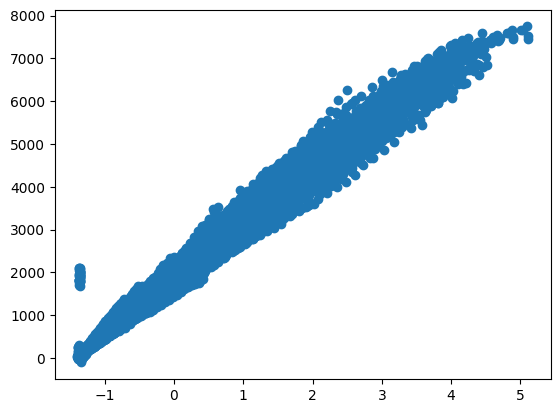

In [ ]:
plt.scatter(y_test[:, 0], y_pred_final[:, 0], label="refuse")

In [ ]:
from sklearn.metrics import r2_score

r2_score(y_test_final[:, 0], y_pred_final[:, 0])

0.9894976019859314

#Build a graph

##Processing data to be ready for a graph

Staten Island = 5, Queens = 4, Brooklyn = 3, Bronx = 2, Manhattan = 1

In [8]:
locations = pd.DataFrame()
recycling_bins = conn.execute("SELECT * FROM bins").fetchdf()

# switch from abreviation to true value
recycling_bins['borough'] = recycling_bins['dsny_zone'].apply(lambda x: 'Manhattan' if x == 'MAN' else ('Bronx' if x == 'BX' else ('Brooklyn' if x == 'BKN' else ('Queens' if x == 'QE' else ('Queens' if x == 'QW' else( 'Staten Island'))))))

# give numeric value for true value
recycling_bins['borough_id'] = recycling_bins['dsny_zone'].apply(lambda x: 1 if x == 'Manhattan' else (2 if x == 'Bronx' else (3 if x == 'Brooklyn' else (4 if x == 'Queens' else 5))))

# clean up address formatting. better for making queries to the address api
recycling_bins['site_location'] = recycling_bins['site_location'].apply(lambda x: x.split(' -')[0])

# drop duplicate values from the dataset
recycling_bins = recycling_bins.drop_duplicates(subset=['site_location'], keep='first')

In [9]:
HERE_API_KEY = "1-CBnuUnC7zb-P-9Lw5kaUWT0bF70gN72NOEaJtrBAc"
geocoder = herepy.GeocoderApi(HERE_API_KEY)

def get_lat_lon_here(address):
    response = geocoder.free_form(address)
    if response.as_dict()['items']:
        location = response.as_dict()['items'][0]['position']
        return location['lat'], location['lng']
    return None

In [44]:
OPENCAGE_API_KEY = "596740f709444a94a58777ea23b70c5e"
geocoder = OpenCageGeocode(OPENCAGE_API_KEY)

def get_lat_lon_opencage(address):
    result = geocoder.geocode(address)
    if result:
        return result[0]["geometry"]["lat"], result[0]["geometry"]["lng"]
    print("no result")
    return None


In [11]:
for index, row in recycling_bins.iterrows():
  point = f"{row['site_location']}, {row['borough']}, NY"

  # clean up address formatting
  point = point.replace('/', ' ')

  # some address start with a letter and then integers. ex: 'b17'. splits up chars and numbers
  match = re.match(r"([a-z]+)([0-9]+)", point, re.I)
  if match:
    # gets chars and numbers
    items = match.groups()
    # split on the character. keep the remainder of the string
    point = point.split(items[0], 1)[1]
  #t.sleep(1)
  location = get_lat_lon_opencage(point)
  # print(f"{location} - {point}")
  if location:
    locations.loc[index, 'latitude'] = location[0]
    locations.loc[index, 'longitude'] = location[1]
    locations.loc[index, 'type'] = 'recycling_bin'

    match = re.match(r"([a-z]+)([0-9]+)", row['dsny_district'], re.I)
    items = match.groups()
    locations.loc[index, 'cd_number'] = int(items[1])

In [13]:
#get_lat_lon_here("New York NY, 10278, USA")

In [14]:
# dropping duplicates
# duplicates are just a general value for the address. specific address can't be found
locations = locations.drop_duplicates(subset=['latitude', 'longitude'], keep=False)

In [15]:
locations['borough_id'] = recycling_bins['borough_id']
locations['borough'] = recycling_bins['borough']

In [16]:
garages = conn.execute("SELECT * FROM garages").fetchdf()

for index, row in garages.iterrows():
  garages.loc[index, 'borocd'] = (int(str(garages['borocd'][index])[1:]))
  garages.loc[index, 'type'] = 'garage'

garages.rename(columns={'boro': 'borough_id', 'borocd': 'cd_number'}, inplace=True)

In [17]:
common_cols = list(set(locations.columns).intersection(garages.columns))
locations_shared = locations[common_cols]
garages_shared = garages[common_cols]

merged = pd.concat([locations_shared, garages_shared], ignore_index=True)

In [18]:
# removes outlier
merged = merged[merged['longitude'] >= -75]
merged.reset_index(inplace=True)

<Axes: xlabel='longitude', ylabel='latitude'>

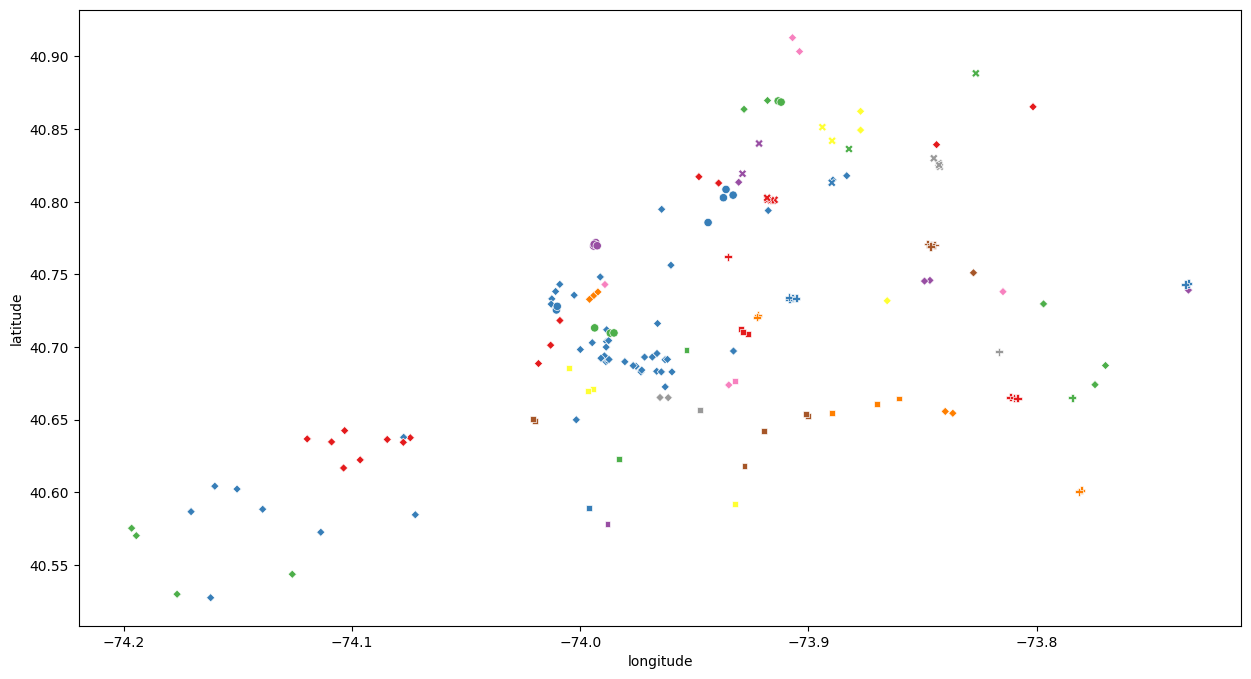

In [19]:
plt.figure(figsize=(15,8))
ax = sns.scatterplot(data=merged, x='longitude', y='latitude', hue='cd_number', style='borough_id', palette='Set1', legend=False)
ax

might need to do some sort of k-clustering for borough and community district ids. some of the spots don't seem to add up to where they should be

random lat/long generator for spots within each boroguh and community id for the bins. take max of the monthly tonnage for each cd and borough and divide by 2.5 then 5.
- dumpsters usually hold 2-3 tons. we'll group 5 dumpsters together at a time

In [20]:
garages = merged[merged['type'] == 'recycling_bin']
print(len(garages))

87


##Adding points to the graph for tonnage pick up points

In [21]:
bins_per_comm = conn.execute("SELECT borough_name, borough_id, community_district, mean(refuse_tons)  from tonnage GROUP BY borough_name, borough_id, community_district ORDER BY borough_id, community_district;").fetchdf()
bins_per_comm['bins_needed'] = bins_per_comm['mean(refuse_tons)'] / 75 / 3
bins_per_comm['bins_needed'] = np.ceil(bins_per_comm['bins_needed']).astype(int)

total = sum(bins_per_comm['bins_needed'])
print(total)

bins_per_comm.head(25)

1027


,borough_name,borough_id,community_district,mean(refuse_tons),bins_needed
0,Manhattan,1,01,1069.761893,5
1,Manhattan,1,02,2305.918204,11
2,Manhattan,1,03,3216.525542,15
3,Manhattan,1,04,2205.774272,10
4,Manhattan,1,05,1335.512560,6
5,Manhattan,1,06,3254.282850,15
6,Manhattan,1,07,5453.392961,25
7,Manhattan,1,08,5812.325604,26
8,Manhattan,1,09,2777.819903,13
9,Manhattan,1,10,2909.235990,13


In [22]:
bins_per_comm = conn.execute("SELECT borough_name, community_district from tonnage GROUP BY borough_name, community_district ORDER BY borough_name, community_district;").fetchdf()
bins_per_comm

,borough_name,community_district
0,Bronx,01
1,Bronx,02
2,Bronx,03
3,Bronx,04
4,Bronx,05
5,Bronx,06
6,Bronx,07
7,Bronx,08
8,Bronx,09
9,Bronx,10


In [23]:
np.random.uniform(-0.01, 0.01)

-0.005422202479374829

In [46]:
get_lat_lon_opencage("New York, NY 11237, USA")

(40.7127281, -74.0060152)

In [52]:
!pip install pgeocode
import pgeocode

def get_lat_lon_offline(zip_code, country="US"):
    nomi = pgeocode.Nominatim(country)
    location = nomi.query_postal_code(zip_code)
    if location.latitude and location.longitude:
        return location.latitude, location.longitude
    else:
        return None

zip_code = "10013"
coordinates = get_lat_lon_offline(zip_code)
print(f"Coordinates for {zip_code}: {coordinates}")


Coordinates for 10013: (40.7185, -74.0025)


In [38]:
merged

,index,cd_number,longitude,borough_id,latitude,type
0,0,2.0,-73.988736,5,40.689939,recycling_bin
1,1,2.0,-73.988201,5,40.690874,recycling_bin
2,2,2.0,-73.988580,5,40.692760,recycling_bin
3,3,2.0,-73.989387,5,40.693898,recycling_bin
4,4,2.0,-73.973354,5,40.682831,recycling_bin
...,...,...,...,...,...,...
162,163,12.0,-73.826637,2,40.888348,garage
163,164,7.0,-73.846428,4,40.769077,garage
164,165,2.0,-73.905304,4,40.733543,garage
165,166,18.0,-73.927986,3,40.618069,garage


In [ ]:
merged_copy = merged.copy()

for index, row in bins_per_comm.iterrows():
  borough_id = row['borough_id']
  cd_number = row['community_district']
  bins_needed = row['bins_needed']
  vals = merged[(merged['borough_id'] == borough_id) & (merged['cd_number'] == cd_number)]
  print(borough_id, cd_number)
  print(vals)

  for _ in range(bins_needed):
    random_row = merged.iloc[np.random.randint(0, len(vals))]
    lon = random_row['longitude'] + np.random.uniform(-0.01, 0.01)
    lat = random_row['latitude'] + np.random.uniform(-0.01, 0.01)

    merged_copy.loc[len(merged_copy)] = {'borough_id': borough_id, 'cd_number': cd_number, 'longitude': lon, 'latitude': lat}'''

##Building Graph

In [26]:
import networkx

In [27]:
G = networkx.Graph()
for i in range(len(merged)):
  #print(i)
  #print(i, merged.loc[i, 'longitude'], merged.loc[i, 'latitude'], merged.loc[i, 'borough_id'], merged.loc[i, 'cd_number'])
  G.add_node(i, longitude=merged.loc[i, 'longitude'], latitude=merged.loc[i, 'latitude'], borough=merged.loc[i, 'borough_id'], cd_number=merged.loc[i, 'cd_number'])


In [28]:
!pip install haversine
import itertools
import haversine as hs
from haversine import Unit

In [29]:
for u, v in itertools.combinations(G.nodes, 2):
  if (G.nodes[u]['borough'] == G.nodes[v]['borough'] and G.nodes[u]['cd_number'] == G.nodes[v]['cd_number']):
        G.add_edge(u, v)
        loc1 = (G.nodes[u]['latitude'], G.nodes[u]['longitude'])
        loc2 = (G.nodes[v]['latitude'], G.nodes[v]['longitude'])
        distance = hs.haversine(loc1, loc2, unit=Unit.KILOMETERS)
        G.edges[u, v]['weight'] = distance

In [30]:
G.nodes(data=True)

NodeDataView({0: {'longitude': -73.9887364, 'latitude': 40.6899394, 'borough': 5, 'cd_number': 2.0}, 1: {'longitude': -73.9882009, 'latitude': 40.6908743, 'borough': 5, 'cd_number': 2.0}, 2: {'longitude': -73.9885801, 'latitude': 40.6927596, 'borough': 5, 'cd_number': 2.0}, 3: {'longitude': -73.989387, 'latitude': 40.693898, 'borough': 5, 'cd_number': 2.0}, 4: {'longitude': -73.9733542, 'latitude': 40.6828309, 'borough': 5, 'cd_number': 2.0}, 5: {'longitude': -74.00171, 'latitude': 40.64994, 'borough': 5, 'cd_number': 2.0}, 6: {'longitude': -73.97552, 'latitude': 40.686757, 'borough': 5, 'cd_number': 2.0}, 7: {'longitude': -73.9885, 'latitude': 40.703823, 'borough': 5, 'cd_number': 2.0}, 8: {'longitude': -73.9999297, 'latitude': 40.6982888, 'borough': 5, 'cd_number': 2.0}, 9: {'longitude': -73.987348, 'latitude': 40.691458, 'borough': 5, 'cd_number': 2.0}, 10: {'longitude': -73.9664761, 'latitude': 40.6833334, 'borough': 5, 'cd_number': 2.0}, 11: {'longitude': -73.973027, 'latitude': 4

In [ ]:
import json
from networkx.readwrite import json_graph

def convert_attributes(G):
    for node, data in G.nodes(data=True):
        for key, value in data.items():
            if isinstance(value, (np.int64, np.float64)):  # Check for NumPy types
                G.nodes[node][key] = value.item()  # Convert to native Python type

    for u, v, data in G.edges(data=True):
        for key, value in data.items():
            if isinstance(value, (np.int64, np.float64)):
                G.edges[u, v][key] = value.item()

# Convert attributes to JSON-safe types
convert_attributes(G)

# Convert graph to JSON-compatible format
graph_data = json_graph.node_link_data(G)

# Save to JSON file
with open("graph.json", "w") as f:
    json.dump(graph_data, f, indent=4)

In [31]:
groups = conn.execute("SELECT borough_name, borough_id, community_district, mean(refuse_tons)  from tonnage GROUP BY borough_name, borough_id, community_district ORDER BY borough_id, community_district;").fetchdf()
groups['bins_needed'] = groups['mean(refuse_tons)'] / 75 / 3
groups['bins_needed'] = np.ceil(groups['bins_needed']).astype(int)

total = sum(groups['bins_needed'])
print(total)

groups.head(25)


1027


,borough_name,borough_id,community_district,mean(refuse_tons),bins_needed
0,Manhattan,1,01,1069.761893,5
1,Manhattan,1,02,2305.918204,11
2,Manhattan,1,03,3216.525542,15
3,Manhattan,1,04,2205.774272,10
4,Manhattan,1,05,1335.512560,6
5,Manhattan,1,06,3254.282850,15
6,Manhattan,1,07,5453.392961,25
7,Manhattan,1,08,5812.325604,26
8,Manhattan,1,09,2777.819903,13
9,Manhattan,1,10,2909.235990,13


In [33]:
!pip install pyvis
from pyvis.network import Network

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 756.0/756.0 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 59.8 MB/s eta 0:00:00


In [34]:
# Convert NetworkX Graph to Pyvis
net = Network(notebook=True, height="800px", width="100%", directed=True)

# Add Nodes
for node, data in G.nodes(data=True):
    net.add_node(node, label=f"Stop {node}\nBins: {data.get('bins_needed', 0)}",
                 title=f"CD: {data['cd_number']}, Borough: {data['borough']}",
                 size=data.get('bins_needed', 1) * 5, color="blue")

# Add Edges
for u, v, data in G.edges(data=True):
    net.add_edge(u, v, title=f"Distance: {data['weight']:.2f} km", color="gray")

# Show Interactive Graph
net.show("waste_collection_graph.html")

waste_collection_graph.html


<ipython-input-35-0b5c6f7cea3b>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=groups, x="borough_name", y="mean(refuse_tons)", palette="coolwarm")


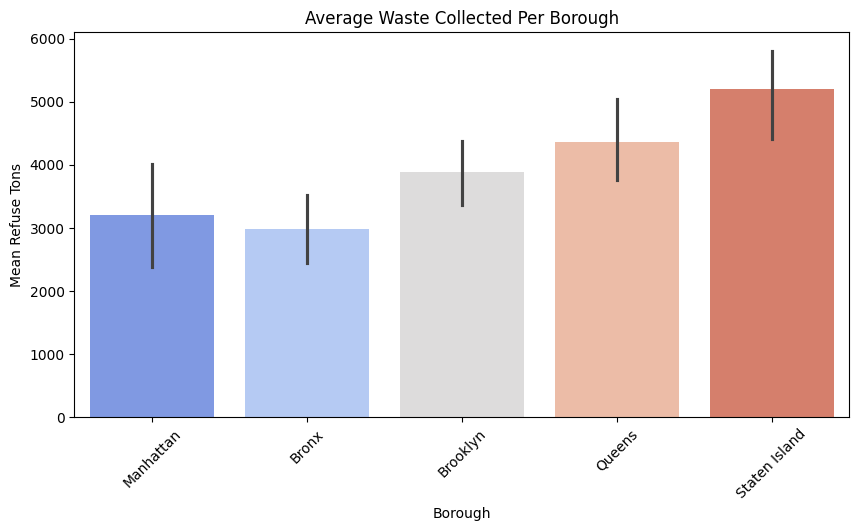

In [35]:
# Plot total waste collection per borough
#import seaborn as sns
#import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.barplot(data=groups, x="borough_name", y="mean(refuse_tons)", palette="coolwarm")
plt.title("Average Waste Collected Per Borough")
plt.ylabel("Mean Refuse Tons")
plt.xlabel("Borough")
plt.xticks(rotation=45)
plt.show()

In [37]:
groups

,borough_name,borough_id,community_district,mean(refuse_tons),bins_needed
0,Manhattan,1,01,1069.761893,5
1,Manhattan,1,02,2305.918204,11
2,Manhattan,1,03,3216.525542,15
3,Manhattan,1,04,2205.774272,10
4,Manhattan,1,05,1335.512560,6
5,Manhattan,1,06,3254.282850,15
6,Manhattan,1,07,5453.392961,25
7,Manhattan,1,08,5812.325604,26
8,Manhattan,1,09,2777.819903,13
9,Manhattan,1,10,2909.235990,13


In [36]:
# collection point
import geopandas as gpd

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(groups, geometry=gpd.points_from_xy(groups['longitude'], groups['latitude']))

# Plot Heatmap
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
fig, ax = plt.subplots(figsize=(10, 7))
world.plot(ax=ax, color="white", edgecolor="black")
gdf.plot(ax=ax, markersize=groups['bins_needed']*10, color="red", alpha=0.5)

plt.title("Waste Collection Points Heatmap")
plt.show()

KeyError: 'longitude'